In [161]:
# Python 3
import http.client, urllib.parse
import json
import pprint
import yfinance
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.linear_model as SKmodels
import joblib

# API keys

In [162]:
API_STOCK_DATA = "Ab0Eq9OSOkVaNe9eluoMjkxSgnrFk46h08ghta6w"
API_ALPHA_VANTAGE = "Y55JGW1SYPKKETDD"

# Stock data API

In [163]:
# conn = http.client.HTTPSConnection('api.stockdata.org')
#
# params = urllib.parse.urlencode({
#     'api_token': API_STOCK_DATA,
#     'symbols': 'AAPL',
#     'interval': 'minute',
#     'date_from': '2021-01-01',
#     'date_to': '2022-01-01'
#     })
#
# conn.request('GET', '/v1/data/intraday?{}'.format(params))
#
# res = conn.getresponse()
# data = res.read()
# json.loads(data.decode('utf-8'))

# Alpha vantage

In [164]:
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={API_ALPHA_VANTAGE}'
# r = requests.get(url)
# dataVIX = r.json()
# dataVIX

# Yfinance

,VIX_Open
Datetime,
2022-04-28 14:31:00+01:00,29.840000
2022-04-28 14:32:00+01:00,29.990000
2022-04-28 14:33:00+01:00,30.360001
2022-04-28 14:34:00+01:00,30.330000
2022-04-28 14:35:00+01:00,30.370001
...,...
2022-05-06 20:56:00+01:00,30.170000
2022-05-06 20:57:00+01:00,30.190001
2022-05-06 20:58:00+01:00,30.100000


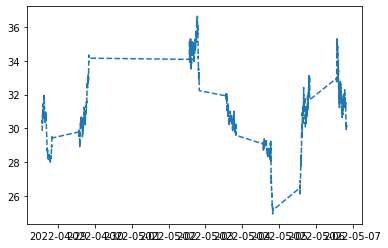

In [165]:
# Download VIX information
ticker = yfinance.Ticker('^VIX')
VIX = ticker.history(interval='1m', period='7d')
VIX.index = pd.to_datetime(VIX.index).tz_convert(tz='Europe/London')
VIX.columns = [f"VIX_{_}" for _ in VIX.columns]
plt.plot(VIX.VIX_Open, '--')
VIX = VIX[["VIX_Open"]]
VIX

,CHFJPY_Open
Datetime,
2022-04-28 00:00:00+01:00,132.600006
2022-04-28 00:01:00+01:00,132.621994
2022-04-28 00:02:00+01:00,132.630005
2022-04-28 00:03:00+01:00,132.617004
2022-04-28 00:04:00+01:00,132.610001
...,...
2022-05-06 21:56:00+01:00,132.029999
2022-05-06 21:57:00+01:00,132.035995
2022-05-06 21:58:00+01:00,132.022995


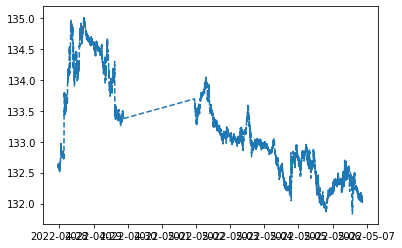

In [166]:
# Download CHFJPY information
ticker = yfinance.Ticker('CHFJPY=X')
CHFJPY = ticker.history(interval='1m', period='7d').iloc[:-15]
CHFJPY.index = pd.to_datetime(CHFJPY.index).tz_convert(tz='Europe/London')
CHFJPY.columns = [f"CHFJPY_{_}" for _ in CHFJPY.columns]
plt.plot(CHFJPY.CHFJPY_Open, '--')
CHFJPY = CHFJPY[["CHFJPY_Open"]]
CHFJPY

,GOLD_Open
Datetime,
2022-04-29 05:00:00+01:00,1905.800049
2022-04-29 05:01:00+01:00,1905.599976
2022-04-29 05:02:00+01:00,1905.699951
2022-04-29 05:03:00+01:00,1905.500000
2022-04-29 05:04:00+01:00,1905.900024
...,...
2022-05-06 21:41:00+01:00,1883.000000
2022-05-06 21:42:00+01:00,1882.900024
2022-05-06 21:43:00+01:00,1882.699951


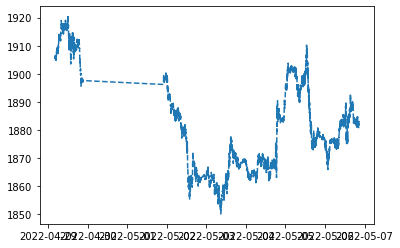

In [167]:
# Download Gold information
ticker = yfinance.Ticker('GC=F')
GOLD = ticker.history(interval='1m', period='7d').iloc[:-15]
GOLD.index = pd.to_datetime(GOLD.index).tz_convert(tz='Europe/London')
GOLD.columns = [f"GOLD_{_}" for _ in GOLD.columns]
plt.plot(GOLD.GOLD_Open, '--')
GOLD = GOLD[["GOLD_Open"]]
GOLD

In [168]:
# Merge both dataFrames. Cut part with causes by yahooFinance shift of VIX
merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
# merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
#              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
#              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
#             axis=1, inplace=True)

del nan
# Create Mean by rolling on rollParam value.
rollParam = 100
CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
merged['CHFJPY_Vol'] = CHFJPY_roll.std()
merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

VIX_roll = merged.rolling(rollParam)['VIX_Open']
merged['VIX_Vol'] = VIX_roll.std()
merged['VIX_Mean'] = VIX_roll.mean()

GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
merged['GOLD_Vol'] = GOLD_roll.std()
merged['GOLD_Mean'] = GOLD_roll.mean()

merged = merged.iloc[rollParam:]

predictionMean = 10
merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
merged = merged.iloc[:-predictionMean]
del CHFJPY_roll, VIX_roll, GOLD_roll

merged

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_491/296508333.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future
Datetime,,,,,,,,,,,,
2022-04-29 06:40:00+01:00,134.563995,29.430000,True,1907.599976,False,0.041057,134.46478,0.000000,29.4300,1.403061,1906.885004,134.47185
2022-04-29 06:41:00+01:00,134.563004,29.430000,True,1907.800049,False,0.042098,134.46544,0.000000,29.4300,1.399954,1906.907004,134.47199
2022-04-29 06:42:00+01:00,134.570007,29.430000,True,1907.500000,False,0.043228,134.46612,0.000000,29.4300,1.395843,1906.925005,134.47246
2022-04-29 06:43:00+01:00,134.552994,29.430000,True,1907.300049,False,0.044073,134.46685,0.000000,29.4300,1.388870,1906.943005,134.47276
2022-04-29 06:44:00+01:00,134.563995,29.430000,True,1907.300049,False,0.045131,134.46779,0.000000,29.4300,1.385302,1906.957006,134.47241
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 21:46:00+01:00,132.087997,30.190001,True,1882.699951,True,0.035884,132.09849,0.571623,30.5451,0.963518,1882.551001,132.09683
2022-05-06 21:47:00+01:00,132.102997,30.190001,True,1882.699951,True,0.035884,132.09849,0.559567,30.5295,0.960632,1882.560000,132.09667
2022-05-06 21:48:00+01:00,132.093002,30.190001,True,1882.699951,True,0.035789,132.09870,0.545868,30.5135,0.959712,1882.557000,132.09621


In [169]:
# merged['Target'] = 1 if (merged['CHFJPY_Mean_Future'] > merged['CHFJPY_Mean']) else 0
merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
# merged['Target'] = merged.apply(lambda x: x.CHFJPY_Mean_Future - x['CHFJPY_Mean'], axis=1)
merged.to_csv('dataNew06_05_22.csv')

In [170]:
train, test = train_test_split(merged, shuffle=False)
scalePandas = MinMaxScaler()
train[train.columns] = scalePandas.fit_transform(train[train.columns])
train


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future,Target
Datetime,,,,,,,,,,,,,
2022-04-29 06:40:00+01:00,0.955978,0.384089,1.0,0.816761,0.0,0.084484,0.996434,0.000000e+00,0.404670,0.154407,0.835824,0.999593,1.0
2022-04-29 06:41:00+01:00,0.955602,0.384089,1.0,0.819603,0.0,0.087741,0.996729,0.000000e+00,0.404670,0.153997,0.836172,0.999656,1.0
2022-04-29 06:42:00+01:00,0.958260,0.384089,1.0,0.815341,0.0,0.091281,0.997033,0.000000e+00,0.404670,0.153455,0.836456,0.999866,1.0
2022-04-29 06:43:00+01:00,0.951803,0.384089,1.0,0.812501,0.0,0.093925,0.997359,0.000000e+00,0.404670,0.152535,0.836741,1.000000,1.0
2022-04-29 06:44:00+01:00,0.955978,0.384089,1.0,0.812501,0.0,0.097235,0.997779,0.000000e+00,0.404670,0.152064,0.836962,0.999844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05 12:26:00+01:00,0.234916,0.018819,1.0,0.676136,0.0,0.200545,0.223342,2.958340e-07,0.000322,0.140027,0.689974,0.221117,0.0
2022-05-05 12:27:00+01:00,0.218216,0.018819,1.0,0.667613,0.0,0.200404,0.223356,2.958340e-07,0.000322,0.138934,0.690132,0.220826,0.0
2022-05-05 12:28:00+01:00,0.218216,0.018819,1.0,0.666193,0.0,0.200215,0.223374,2.958340e-07,0.000322,0.137719,0.690290,0.220598,0.0


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_491/3772619759.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_491/3772619759.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)


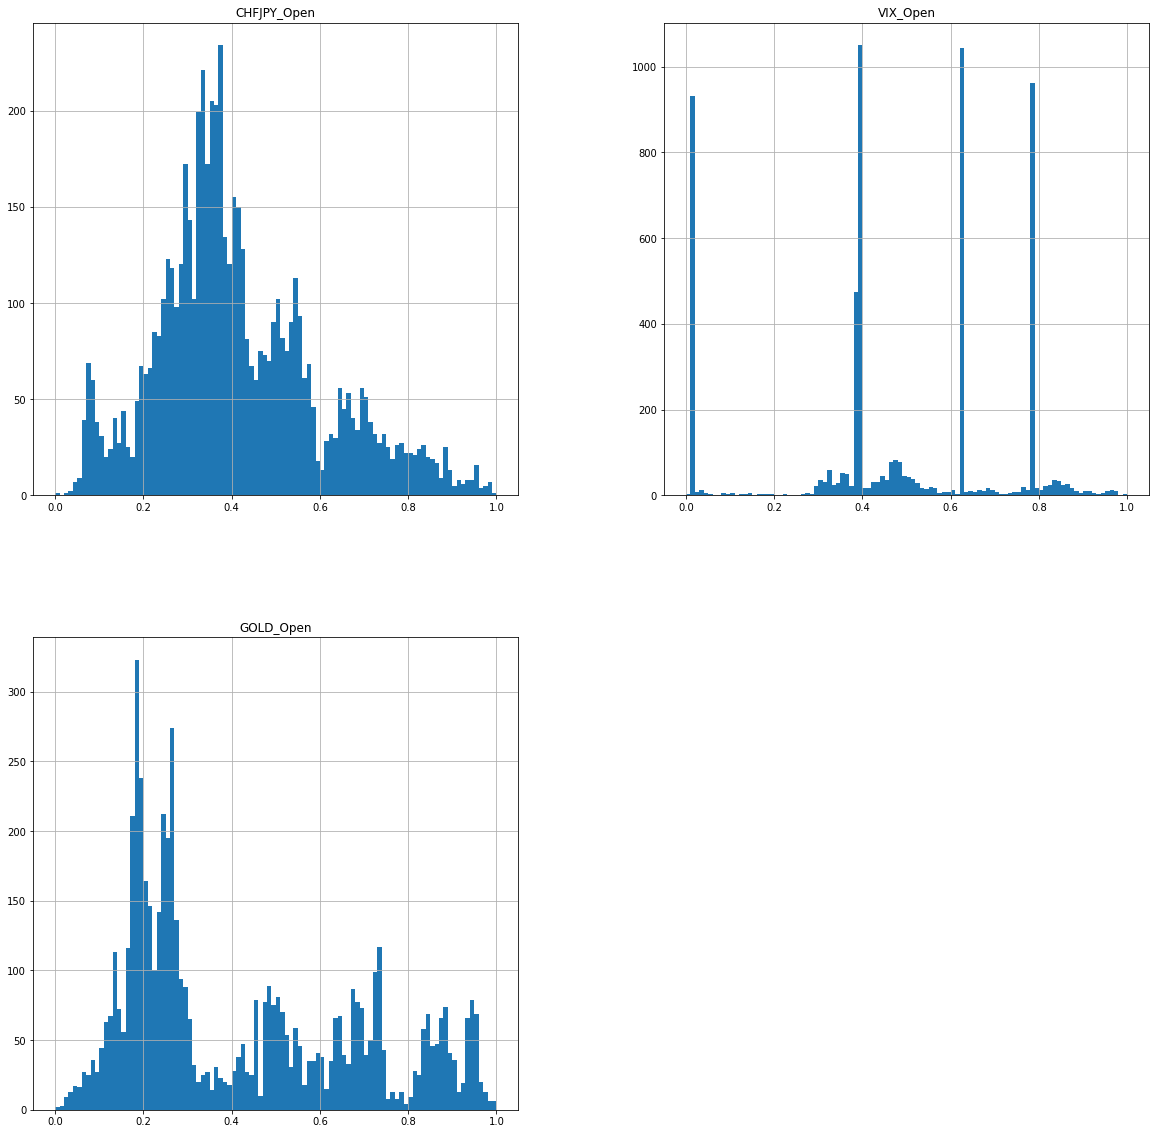

array([[<AxesSubplot:title={'center':'CHFJPY_Vol'}>,
        <AxesSubplot:title={'center':'VIX_Vol'}>],
       [<AxesSubplot:title={'center':'GOLD_Vol'}>, <AxesSubplot:>]],
      dtype=object)

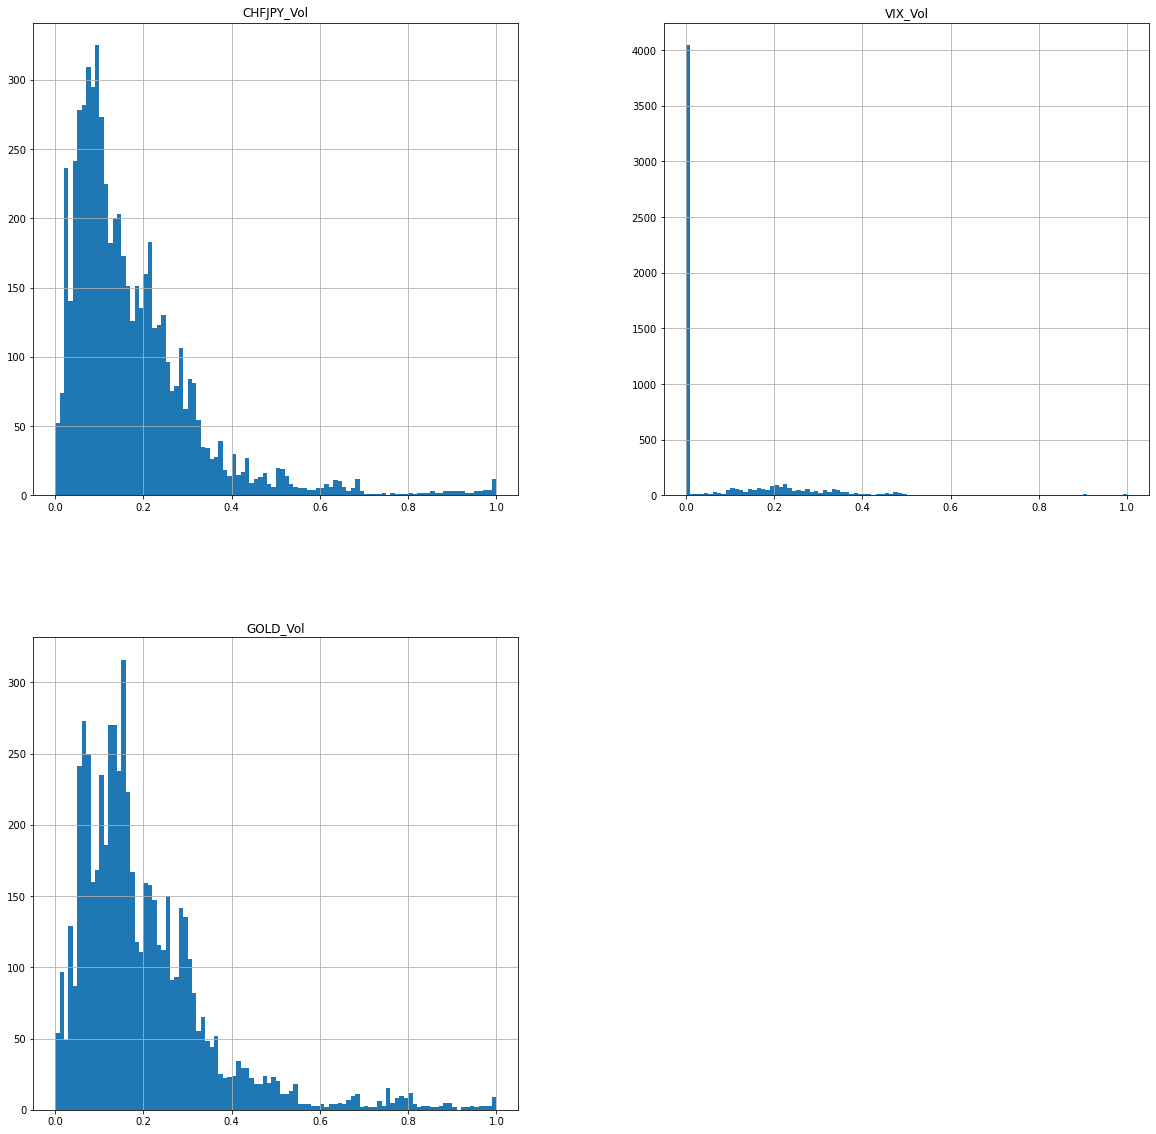

In [171]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set_title('Open Histogram')
train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
plt.show()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)

# Train Batch

In [172]:
trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = trainShifted.columns
for sf in SHIFT_ARRAY:
    shifted = trainShifted.shift(sf)
    for column in trainColumns:
        trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
train = train.iloc[max(SHIFT_ARRAY):]
train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)
train

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_491/1358549267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-29 07:40:00+01:00,0.821637,0.384089,1.0,0.899148,0.0,0.304630,0.973683,0.000000e+00,0.404670,0.216622,...,0.000000e+00,0.404670,0.156452,0.842444,0.996434,0.084484,0.000000e+00,0.404670,0.154407,0.835824
2022-04-29 07:41:00+01:00,0.835674,0.384089,1.0,0.890626,0.0,0.307596,0.972584,0.000000e+00,0.404670,0.218668,...,0.000000e+00,0.404670,0.155753,0.842728,0.996729,0.087741,0.000000e+00,0.404670,0.153997,0.836172
2022-04-29 07:42:00+01:00,0.830740,0.384089,1.0,0.883523,0.0,0.311508,0.971547,0.000000e+00,0.404670,0.220173,...,0.000000e+00,0.404670,0.154683,0.843139,0.997033,0.091281,0.000000e+00,0.404670,0.153455,0.836456
2022-04-29 07:43:00+01:00,0.833022,0.384089,1.0,0.883523,0.0,0.314932,0.970533,0.000000e+00,0.404670,0.221527,...,0.000000e+00,0.404670,0.154299,0.843692,0.997359,0.093925,0.000000e+00,0.404670,0.152535,0.836741
2022-04-29 07:44:00+01:00,0.825430,0.384089,1.0,0.884944,0.0,0.319321,0.969482,0.000000e+00,0.404670,0.223740,...,0.000000e+00,0.404670,0.153061,0.844150,0.997779,0.097235,0.000000e+00,0.404670,0.152064,0.836962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05 12:26:00+01:00,0.234916,0.018819,1.0,0.676136,0.0,0.200545,0.223342,2.958340e-07,0.000322,0.140027,...,2.958340e-07,0.000322,0.174030,0.675408,0.177148,0.166614,2.958340e-07,0.000322,0.245130,0.662422
2022-05-05 12:27:00+01:00,0.218216,0.018819,1.0,0.667613,0.0,0.200404,0.223356,2.958340e-07,0.000322,0.138934,...,2.958340e-07,0.000322,0.172801,0.675551,0.178592,0.169396,2.958340e-07,0.000322,0.239188,0.663639
2022-05-05 12:28:00+01:00,0.218216,0.018819,1.0,0.666193,0.0,0.200215,0.223374,2.958340e-07,0.000322,0.137719,...,2.958340e-07,0.000322,0.171183,0.675724,0.179968,0.173047,2.958340e-07,0.000322,0.233225,0.664808


# Test Batch

In [173]:
testB = test
testB[testB.columns] = scalePandas.transform(testB[testB.columns])
testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = testShifted.columns
for sf in SHIFT_ARRAY:
    shifted = testShifted.shift(sf)
    for column in trainColumns:
        testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
testB = testB.iloc[max(SHIFT_ARRAY):]
testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
testB

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_491/264019191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-05 13:31:00+01:00,0.141939,0.018819,1.0,0.767045,0.0,0.330750,0.160301,2.958340e-07,0.000322,0.222136,...,2.958340e-07,0.000322,0.131471,0.687715,0.222846,0.204524,2.958340e-07,0.000322,0.136634,0.690385
2022-05-05 13:32:00+01:00,0.132830,0.018819,1.0,0.785512,0.0,0.333245,0.158790,2.958340e-07,0.000322,0.235089,...,2.958340e-07,0.000322,0.131888,0.687873,0.222600,0.206725,2.958340e-07,0.000322,0.136021,0.690575
2022-05-05 13:33:00+01:00,0.123721,0.018819,1.0,0.795454,0.0,0.337172,0.157231,2.958340e-07,0.000322,0.250287,...,2.958340e-07,0.000322,0.131977,0.687889,0.222399,0.208502,2.958340e-07,0.000322,0.136056,0.690433
2022-05-05 13:34:00+01:00,0.127138,0.018819,1.0,0.786932,0.0,0.339974,0.155676,2.958340e-07,0.000322,0.262098,...,2.958340e-07,0.000322,0.132056,0.687905,0.221966,0.212378,2.958340e-07,0.000322,0.135997,0.690117
2022-05-05 13:35:00+01:00,0.141180,0.018819,1.0,0.789772,0.0,0.340981,0.154317,2.958340e-07,0.000322,0.273738,...,2.958340e-07,0.000322,0.131909,0.687873,0.221524,0.216349,2.958340e-07,0.000322,0.136004,0.689974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 21:46:00+01:00,0.016319,0.449102,1.0,0.463068,1.0,0.068292,-0.061017,3.850567e-01,0.510265,0.096411,...,4.869042e-01,0.571258,0.093666,0.456365,-0.055699,0.056317,3.336279e-01,0.601542,0.082252,0.457408
2022-05-06 21:47:00+01:00,0.022011,0.449102,1.0,0.463068,1.0,0.068292,-0.061017,3.769362e-01,0.508788,0.096030,...,4.892832e-01,0.569667,0.093426,0.456223,-0.055516,0.057359,3.466121e-01,0.599733,0.084359,0.457692
2022-05-06 21:48:00+01:00,0.018218,0.449102,1.0,0.463068,1.0,0.067994,-0.060923,3.677082e-01,0.507273,0.095908,...,4.918903e-01,0.568152,0.093132,0.456112,-0.055355,0.058095,3.586387e-01,0.597849,0.086347,0.457992


# Forest

In [174]:
data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
target = train.Target
testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
testTarget = testB.Target

In [175]:
forest = RandomForestRegressor(verbose=1, n_estimators=20, min_samples_leaf=43, n_jobs=-1,
                                max_depth=34, min_samples_split=40)
forest.fit(X=data, y=target)
# Train Score
# print('Train Score', forest.score(X=data, y=target))
print('Train Score', forest.score(X=data, y=target))
# Test Score
print('Test Score', forest.score(X=testData, y=testTarget))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Train Score 0.8145426990330007
Test Score -0.3597742977073992


# Ridge Classifier

In [176]:
classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
classifier.fit(X=data, y=target)
# Train Score
print('Train Score', classifier.score(X=data, y=target))
# Test Score
print('Test Score', classifier.score(X=testData, y=testTarget))

Train Score 0.8841803140300524
Test Score 0.8232558139534883


In [177]:
pd.Series(index=list(train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).columns), data=classifier.coef_[0])

CHFJPY_Open               10.815172
VIX_Open                  -1.033336
FiniteVixData              0.128968
GOLD_Open                  0.296011
FiniteGOLDData            -0.174706
CHFJPY_Vol                 0.820285
CHFJPY_Mean                1.839988
VIX_Vol                    0.381535
VIX_Mean                   0.193676
GOLD_Vol                  -1.219065
GOLD_Mean                 -0.994666
SHIFTED_5_CHFJPY_Mean      0.732874
SHIFTED_5_CHFJPY_Vol       0.124438
SHIFTED_5_VIX_Vol          0.562937
SHIFTED_5_VIX_Mean         0.255588
SHIFTED_5_GOLD_Vol         0.173620
SHIFTED_5_GOLD_Mean       -0.926396
SHIFTED_10_CHFJPY_Mean    -0.228846
SHIFTED_10_CHFJPY_Vol     -0.002043
SHIFTED_10_VIX_Vol         0.378703
SHIFTED_10_VIX_Mean        0.285489
SHIFTED_10_GOLD_Vol        0.673991
SHIFTED_10_GOLD_Mean      -0.765175
SHIFTED_15_CHFJPY_Mean    -1.078911
SHIFTED_15_CHFJPY_Vol      0.327318
SHIFTED_15_VIX_Vol        -0.143995
SHIFTED_15_VIX_Mean        0.303462
SHIFTED_15_GOLD_Vol        0

In [178]:
print(classifier.predict(testData))

[0. 0. 0. ... 0. 0. 0.]


In [179]:
classifier = SKmodels.LogisticRegression(penalty='elasticnet', l1_ratio=0.4, C=0.5, solver='saga')
classifier.fit(X=trainShifted.values, y=train.Target)
# Train Score
print('Train Score', classifier.score(X=trainShifted.values, y=train.Target))
# Test Score
print('Test Score', classifier.score(X=testShifted.values, y=testB.Target))

Train Score 0.7683606280601046
Test Score 0.668733850129199


In [180]:
import warnings


def make_score(value):
    warnings.filterwarnings("ignore")
    merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

    merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
    # merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
    #              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
    #              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
    #             axis=1, inplace=True)

    del nan
    # Create Mean by rolling on rollParam value.
    rollParam = value
    CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
    merged['CHFJPY_Vol'] = CHFJPY_roll.std()
    merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

    VIX_roll = merged.rolling(rollParam)['VIX_Open']
    merged['VIX_Vol'] = VIX_roll.std()
    merged['VIX_Mean'] = VIX_roll.mean()

    GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
    merged['GOLD_Vol'] = GOLD_roll.std()
    merged['GOLD_Mean'] = GOLD_roll.mean()

    merged = merged.iloc[rollParam:]

    predictionMean = value
    merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
    merged = merged.iloc[:-predictionMean]
    del CHFJPY_roll, VIX_roll, GOLD_roll
    merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
    # merged['Target'] = merged.apply(lambda x: x.CHFJPY_Mean_Future - x['CHFJPY_Mean'], axis=1)
    train, test = train_test_split(merged, shuffle=False)
    scalePandas = MinMaxScaler()
    train[train.columns] = scalePandas.fit_transform(train[train.columns])
    trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = trainShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = trainShifted.shift(sf)
        for column in trainColumns:
            trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
    train = train.iloc[max(SHIFT_ARRAY):]
    train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)

    testB = test
    testB[testB.columns] = scalePandas.transform(testB[testB.columns])
    testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = testShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = testShifted.shift(sf)
        for column in trainColumns:
            testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
    testB = testB.iloc[max(SHIFT_ARRAY):]
    testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
    data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    target = train.Target
    testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    testTarget = testB.Target
    classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
    classifier.fit(X=data, y=target)
    return [value, classifier.score(X=testData, y=testTarget)]

with pd.option_context('mode.chained_assignment',None):
    RES = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(make_score)(x) for x in list(range(10, 400, 5)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   17.0s finished


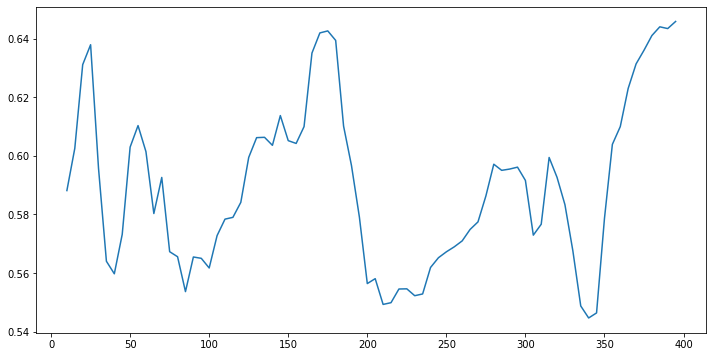

In [181]:
plt.figure(figsize=(12,6))
plt.plot([x[0] for x in RES], [x[1] for x in RES])

In [192]:
import pandas as pd

class Strategy:
    # TODO: Сделать закачку данных
    def __init__(self, dataFrame, hoursAvailable='all'):
        self.DEBUG = True
        self.BASE = 'CHFJPY'
        self.data = dataFrame

        self.data.index = pd.to_datetime(self.data.index)
        self.dataIDX = self.data.index

        self.technicalData = self.data.copy()
        self.technicalDataTestBatch = None
        self.trainSize = 0.5
        self.model = None
        self.scalePandas = None

        self.testData = None
        self.testIDX = None

        self.testSHIFTED = None
        self.testSHIFTEDIDX = None
        self.TimeBorder = pd.Timedelta('300T')
        self.intTimeBorder = self.TimeBorder // '1T'
        self.Y_threshold = 1    # In sigmas
        self.scanTime = pd.Timedelta('400T')  # For collecting half-time
        self.intScanTime = self.scanTime // '1T'
        self.scanTimeSimplifier = pd.Timedelta('1T')
        self.intScanTimeSimplifier = self.scanTimeSimplifier // '1T'
        self.intBbandsNanShift = self.intScanTimeSimplifier + self.intScanTime
        if hoursAvailable == 'all':
            self.availableToTradeHours = [i for i in range(0, 25)]
        else:
            self.availableToTradeHours = hoursAvailable

        self.idxPos = self.data.index
        def _applyer(x, inSID):
            if self.idxPos.get_loc(x.name) % inSID.intScanTimeSimplifier != 0:
                return -666
            if (self.idxPos.get_loc(x.name)) > self.intScanTime:
                POS = self.idxPos.get_loc(x.name)
                return self.get_half_time(inSID.technicalData[f"{self.BASE}_Open"].iloc[POS-self.intScanTime:POS])
            else:
                return np.nan
        self.technicalData["HalfTime"] = self.technicalData[f"{self.BASE}_Open"].to_frame().apply(lambda x: _applyer(x, inSID=self), axis=1)
        self.technicalData["HalfTime"].replace(to_replace = -666,  method='ffill', inplace=True)
        self.technicalData[["Mean", "Std", "HighBand", "LowBand"]] = self.technicalData[f"{self.BASE}_Open"].to_frame().apply(lambda x: self.calculate_BBands(x.name), axis=1, result_type='expand')
        self.technicalDataTestBatch = sklearn.model_selection.train_test_split(self.technicalData, test_size=self.trainSize,
                                                               train_size=1-self.trainSize, shuffle=False)[1]
    def calculate_BBands(self, position):
        _pos = (self.idxPos.get_loc(position))
        if (_pos < self.intBbandsNanShift) or (_pos < self.technicalData["HalfTime"].loc[position]):
            return np.nan, np.nan, np.nan, np.nan

        try:
            roll = self.technicalData[f"{self.BASE}_Open"].rolling(int(self.technicalData["HalfTime"].loc[position]))
        except ValueError:
            if self.DEBUG:
                pass
                # print('Incorrect HalfTime')
            return np.nan, np.nan, np.nan, np.nan

        mean, std = roll.mean().loc[position], roll.std().loc[position]
        HighB = self.Y_threshold * std + mean
        LowB = mean - self.Y_threshold * std
        return mean, std, HighB, LowB

    def get_half_time(self, openTuple: pd.Series) -> float:
        """
        Функция отдающая период полураспада
        :param openTuple:
        :return:
        """
        df_open = openTuple.to_frame()
        df_lag = df_open.shift(1)
        df_delta = df_open - df_lag
        linear_regression_model = LinearRegression()
        df_delta = df_delta.values.reshape(len(df_delta), 1)
        df_lag = df_lag.values.reshape(len(df_lag), 1)
        linear_regression_model.fit(df_lag[1:], df_delta[1:])
        half_life = -np.log(2) / linear_regression_model.coef_.item()
        return int(half_life)

    def train_model(self):
        train, test = sklearn.model_selection.train_test_split(self.data, test_size=1 - self.trainSize,
                                                               train_size=self.trainSize,
                                                               shuffle=False)
        # print(train.iloc[0], train.iloc[-1])
        assert train.iloc[-1].name + pd.Timedelta('1T') == test.iloc[0].name
        # print(test.iloc[0], test.iloc[-1])
        self.testData = test
        self.testIDX = test.index
        self.scalePandas = MinMaxScaler()
        train[train.columns] = self.scalePandas.fit_transform(train[train.columns])
        trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
        SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
        trainColumns = trainShifted.columns
        for sf in SHIFT_ARRAY:
            shifted = trainShifted.shift(sf)
            for column in trainColumns:
                trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
        del trainColumns
        trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
        train = train.iloc[max(SHIFT_ARRAY):]
        train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)
        trainData = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
        trainTarget = train.Target
        classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
        classifier.fit(X=trainData, y=trainTarget)
        self.model = classifier

        TEST = self.data.copy()
        TEST[TEST.columns] = self.scalePandas.transform(TEST[TEST.columns])
        TESTShifted = TEST[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
        SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
        TESTColumns = TESTShifted.columns
        for sf in SHIFT_ARRAY:
            shifted = TESTShifted.shift(sf)
            for column in TESTColumns:
                TESTShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
        del TESTColumns
        TESTShifted = TESTShifted.iloc[max(SHIFT_ARRAY):]
        TEST = TEST.iloc[max(SHIFT_ARRAY):]
        TEST = TEST.merge(TESTShifted[list(filter(lambda x: x not in TEST.columns, TESTShifted.columns))], left_index=True, right_index=True)
        self.testSHIFTED = TEST.drop(['Target', 'CHFJPY_Mean_Future'], axis=1)
        self.testSHIFTEDIDX = self.testSHIFTED.index
        TESTTarget = TEST.Target
        if self.DEBUG:
            pass
            # print(TEST.iloc[0,:])
            # print(TEST.iloc[TEST.index.get_loc(self.testData.iloc[0].name):])

        return pd.Series(index=list(train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).columns), data=classifier.coef_[0])

    def _open_position_ability(self, x):
        PreProcessedData = self.testSHIFTED.iloc[self.testSHIFTEDIDX.get_loc(x.name)]
        assert PreProcessedData.name == x.name

        assert 'CHFJPY_Mean_Future' not in PreProcessedData.index
        assert 'Target' not in PreProcessedData.index
        predictor = self.model.predict(X=PreProcessedData.values.reshape(1,-1))
        # print('predictor:', predictor)
        # lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0
        if (x.name.weekday() >= 5) or (x.name.weekday() < 2):
            return 0
        if x["HalfTime"] is not np.nan:
            if x["HighBand"] < x[f"{self.BASE}_Open"]:
                if x["CHFJPY_Vol"] < 0.25:
                    if predictor == 0:
                        return -1
            if x["LowBand"] > x[f"{self.BASE}_Open"]:
                if x["CHFJPY_Vol"] < 0.25:
                    if predictor == 1:
                        return 1
        else:
            return 0

        return 0
    def simulate_trading(self):
        self.technicalDataTestBatch['OPEN'] = self.technicalDataTestBatch.apply(lambda x: self._open_position_ability(x), axis=1)
        return self.technicalDataTestBatch

strategy = Strategy(dataFrame=pd.read_csv('dataNew06_05_22.csv.csv', index_col=0).iloc[:])
strategy.train_model()
z = strategy.simulate_trading()

FileNotFoundError: [Errno 2] No such file or directory: 'dataNew06_05_22.csv.csv'

In [ ]:
global TradeVolume
global SHIFT
global THRESHOLD_LOSS
global SLIPPADGE

SHIFT = 300
TradeVolume = 1000
SLIPPADGE = 0.1

THRESHOLD_LOSS = 0.01
def make_profit(DF, DFIDX, x):
    # print(DF.iloc[DFIDX.get_loc(x.name + pd.Timedelta(f"{SHIFT}T"))])
    # if DFIDX.get_loc(x.name + pd.Timedelta(f"{SHIFT}T")) in DFIDX:
    if x.name + pd.Timedelta(f"{SHIFT}T") < DF.iloc[-1].name:
        # self.technicalData[["Mean", "Std", "HighBand", "LowBand"]] = self.technicalData[f"{self.BASE}_Open"].to_frame().apply(lambda x: self.calculate_BBands(x.name), axis=1, result_type='expand')
        # NEXT_DOT = DF.iloc[DFIDX.get_loc(x.name) + int(x["HalfTime"])]
        # assert x.name + pd.Timedelta(f"{int(x['HalfTime'])}T") == NEXT_DOT.name
        # print(x.name + pd.Timedelta(f"{SHIFT}T"))
        try:
            if x["OPEN"] != 0:
                NEXT_DOT = DF.iloc[DFIDX.get_loc(x.name + pd.Timedelta(f"{SHIFT}T"))]
                assert x.name + pd.Timedelta(f"{SHIFT}T") == NEXT_DOT.name

            if x["OPEN"] == 1:
                CROSS_MEAN = DF.iloc[DFIDX.get_loc(x.name) + int(x["HalfTime"]):DFIDX.get_loc(x.name) + max(int(SHIFT), int(x["HalfTime"]))]
                # Stop loss
                if CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open < x['CHFJPY_Open'] * (1 - THRESHOLD_LOSS)).first_valid_index() is not None:
                    CLOSE_PRICE = CROSS_MEAN.loc[CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open < x['CHFJPY_Open'] * (1 - THRESHOLD_LOSS)).first_valid_index()]["CHFJPY_Open"]
                    print('Stop loss:', (TradeVolume // x["CHFJPY_Open"]) * (CLOSE_PRICE - x["CHFJPY_Open"]) - SLIPPADGE)
                    return (TradeVolume // x["CHFJPY_Open"]) * (CLOSE_PRICE - x["CHFJPY_Open"]) - SLIPPADGE, CLOSE_PRICE
                # Mean crossing
                if CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open > x['CHFJPY_Mean']).first_valid_index() is not None:
                    CLOSE_PRICE = CROSS_MEAN.loc[CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open > x['CHFJPY_Mean']).first_valid_index()]["CHFJPY_Open"]
                    return (TradeVolume // x["CHFJPY_Open"]) * (CLOSE_PRICE - x["CHFJPY_Open"]) - SLIPPADGE, CLOSE_PRICE
                return (TradeVolume // x["CHFJPY_Open"]) * (NEXT_DOT["CHFJPY_Open"] - x["CHFJPY_Open"]) - SLIPPADGE, NEXT_DOT["CHFJPY_Open"]

            if x["OPEN"] == 0:
                return 0, x["CHFJPY_Open"]

            if x["OPEN"] == -1:
                CROSS_MEAN = DF.iloc[DFIDX.get_loc(x.name) + int(x["HalfTime"]):DFIDX.get_loc(x.name) + max(int(SHIFT), int(x["HalfTime"]))]
                # Stop loss
                if CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open > x['CHFJPY_Open'] * (1 + THRESHOLD_LOSS)).first_valid_index() is not None:
                    CLOSE_PRICE = CROSS_MEAN.loc[CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open > x['CHFJPY_Open'] * (1 + THRESHOLD_LOSS)).first_valid_index()]["CHFJPY_Open"]
                    print('Stop loss:', (TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - CLOSE_PRICE) - SLIPPADGE)
                    return (TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - CLOSE_PRICE) - SLIPPADGE, CLOSE_PRICE
                # Mean crossing
                if CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open < x['CHFJPY_Mean']).first_valid_index() is not None:
                    CLOSE_PRICE = CROSS_MEAN.loc[CROSS_MEAN.where(CROSS_MEAN.CHFJPY_Open < x['CHFJPY_Mean']).first_valid_index()]["CHFJPY_Open"]
                    return (TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - CLOSE_PRICE) - SLIPPADGE, CLOSE_PRICE


                return (TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - NEXT_DOT["CHFJPY_Open"]) - SLIPPADGE, NEXT_DOT["CHFJPY_Open"]
        except KeyError:
            print('KEY ERROR')
            NEXT_DOT = DF.iloc[DFIDX.get_loc(x.name) + int(x["HalfTime"]):].iloc[0]
            if x["OPEN"] == 1:
                # print((TradeVolume // x["CHFJPY_Open"]) * (NEXT_DOT["CHFJPY_Open"] - x["CHFJPY_Open"]) - 3, NEXT_DOT["CHFJPY_Open"])
                return (TradeVolume // x["CHFJPY_Open"]) * (NEXT_DOT["CHFJPY_Open"] - x["CHFJPY_Open"]) - SLIPPADGE, NEXT_DOT["CHFJPY_Open"]
            if x["OPEN"] == 0:
                return 0, x["CHFJPY_Open"]
            if x["OPEN"] == -1:
                # print((TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - NEXT_DOT["CHFJPY_Open"]) - 3, NEXT_DOT["CHFJPY_Open"])
                return (TradeVolume // x["CHFJPY_Open"]) * (x["CHFJPY_Open"] - NEXT_DOT["CHFJPY_Open"]) - SLIPPADGE, NEXT_DOT["CHFJPY_Open"]

    else:
        return 0, x["CHFJPY_Open"]
df = z
dfIDX = z.index
z[["PROFIT", "CLOSE_PRICE"]] = z.apply(lambda x: make_profit(df, dfIDX, x), axis=1, result_type='expand')
# z.iloc[3650:].apply(lambda x: make_profit(df, dfIDX, x), axis=1).values

In [ ]:
fig, axs = plt.subplots(2, figsize=(12,12))
axs[0].plot(z["PROFIT"].cumsum())
axs[1].plot(z["CHFJPY_Vol"])
fig.show()

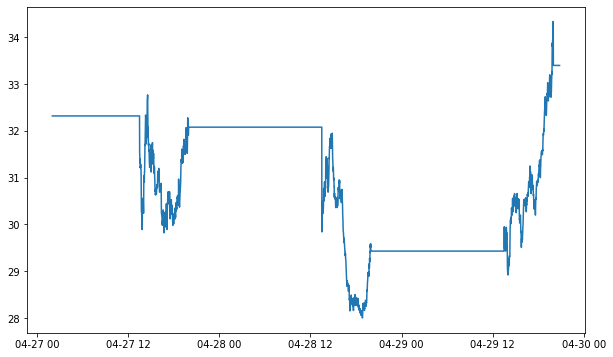

In [185]:
plt.figure(figsize=(10,6))
plt.plot(z["VIX_Open"])
plt.show()

In [186]:
sum(abs(z["OPEN"]))

397

In [187]:
z.loc['2022-04-27 04:00:00':].head(50)

,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,CHFJPY_Mean_Future,Target,HalfTime,Mean,Std,HighBand,LowBand,OPEN,PROFIT,CLOSE_PRICE
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-27 04:00:00+01:00,132.667999,32.32,True,1899.699951,False,0.042959,132.495739,8.697330e-07,32.32,1.369130,...,132.509799,1,110.0,132.494081,0.042074,132.536156,132.452007,0,0.0,132.667999
2022-04-27 04:01:00+01:00,132.675995,32.32,True,1899.900024,False,0.046576,132.497629,8.697330e-07,32.32,1.393816,...,132.511469,1,168.0,132.456928,0.080949,132.537877,132.375979,0,0.0,132.675995
2022-04-27 04:02:00+01:00,132.641006,32.32,True,1900.199951,False,0.048724,132.499139,8.697330e-07,32.32,1.413601,...,132.513340,1,186.0,132.443032,0.091994,132.535026,132.351039,0,0.0,132.641006
2022-04-27 04:03:00+01:00,132.647995,32.32,True,1899.800049,False,0.050947,132.500629,8.697330e-07,32.32,1.442086,...,132.515050,1,129.0,132.498767,0.046420,132.545187,132.452347,0,0.0,132.647995
2022-04-27 04:04:00+01:00,132.667999,32.32,True,1899.300049,False,0.053525,132.501959,8.697330e-07,32.32,1.477434,...,132.516850,1,137.0,132.492664,0.057982,132.550646,132.434682,0,0.0,132.667999
2022-04-27 04:05:00+01:00,132.667999,32.32,True,1899.099976,False,0.056017,132.503439,8.697330e-07,32.32,1.517104,...,132.518880,1,164.0,132.466622,0.084299,132.550921,132.382323,0,0.0,132.667999
2022-04-27 04:06:00+01:00,132.639999,32.32,True,1899.199951,False,0.057656,132.504749,8.697330e-07,32.32,1.549620,...,132.521010,1,169.0,132.465094,0.085745,132.550839,132.379350,0,0.0,132.639999
2022-04-27 04:07:00+01:00,132.634003,32.32,True,1899.000000,False,0.059068,132.505879,8.697330e-07,32.32,1.585984,...,132.522940,1,132.0,132.503265,0.053017,132.556282,132.450248,0,0.0,132.634003
2022-04-27 04:08:00+01:00,132.619995,32.32,True,1899.099976,False,0.060138,132.506849,8.697330e-07,32.32,1.619387,...,132.525100,1,125.0,132.504991,0.055108,132.560099,132.449884,0,0.0,132.619995


In [188]:
"""# UnitTest
a = []
for i in range(0, strategy.technicalData.shape[0]):
    if (i < 420) or (i < strategy.technicalData["HalfTime"].iloc[i]):
       a.append(np.nan)
    else:
        mean = strategy.technicalData["CHFJPY_Open"].rolling(int(strategy.technicalData.iloc[i]["HalfTime"]))
        a.append(mean.mean()[-1])
#   Must be True
sum(np.logical_not(strategy.technicalData["Mean"] == a)) == strategy.intBbandsNanShift"""

'# UnitTest\na = []\nfor i in range(0, strategy.technicalData.shape[0]):\n    if (i < 420) or (i < strategy.technicalData["HalfTime"].iloc[i]):\n       a.append(np.nan)\n    else:\n        mean = strategy.technicalData["CHFJPY_Open"].rolling(int(strategy.technicalData.iloc[i]["HalfTime"]))\n        a.append(mean.mean()[-1])\n#   Must be True\nsum(np.logical_not(strategy.technicalData["Mean"] == a)) == strategy.intBbandsNanShift'

<AxesSubplot:xlabel='Datetime'>

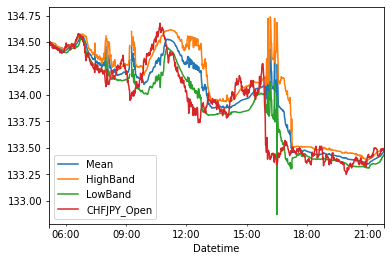

In [189]:
strategy.technicalData.iloc[-1000:][["Mean",  "HighBand", "LowBand", "CHFJPY_Open"]].plot()